# Leetcode - similar problem and topic tag prediction

## 1. Predicting Topic tags for a new question/problem

### Index:
1. [Basic Text Preprocessing](#text_preprocessing)
2. [Basic Feature transformation](#feature_transformation)
3. [Target Variable Transformation](#target_transformation)
4. [Target Variable Analysis](#target_var_analysis)
5. [Making data model-ready](#data_model_ready)
6. [Featurization](#featurization)
7. [Model Training](#training)
8. [Summary Report (model performace metrics report)](#summary)
9. [Conclusion](#conc)

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('data_raw_tag_prediction.csv')

In [26]:
df = data.copy()
data

,question_id,question_title,question_slug,question_text,difficulty,success_rate,likes,dislikes,total_accepted,total_submissions,hints_transformed,similar_question_text_transformed,similar_questions_difficulty,target
0,1,Two Sum,two-sum,Given an array of integers nums and an integer...,Easy,48.4,30564,960,6255310,12924189,A really brute force way would be to search fo...,3Sum 4Sum Two Sum II - Input Array Is Sorted T...,"Easy,Medium","Array,Hash Table"
1,2,Add Two Numbers,add-two-numbers,You are given two non-empty linked lists repre...,Medium,38.4,17483,3629,2644334,6888606,nonexistent,Multiply Strings Add Binary Sum of Two Integer...,"Easy,Medium","Linked List,Math,Recursion"
2,3,Longest Substring Without Repeating Characters,longest-substring-without-repeating-characters,"Given a string s, find the length of the longe...",Medium,32.9,22404,1004,3109972,9438634,nonexistent,Longest Substring with At Most Two Distinct Ch...,"Hard,Medium","Hash Table,String,Sliding Window"
3,4,Median of Two Sorted Arrays,median-of-two-sorted-arrays,Given two sorted arrays nums1 and nums2 of siz...,Hard,33.9,15640,1936,1312772,3874658,nonexistent,nonexistent,nonexistent,"Array,Binary Search,Divide and Conquer"
4,5,Longest Palindromic Substring,longest-palindromic-substring,"Given a string s, return the longest palindrom...",Medium,31.7,16733,981,1752820,5525765,How can we reuse a previously computed palindr...,Shortest Palindrome Palindrome Permutation Pal...,"Hard,Medium,Easy","String,Dynamic Programming"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,2311,Minimum White Tiles After Covering With Carpets,minimum-white-tiles-after-covering-with-carpets,"You are given a 0-indexed binary string floor,...",Hard,31.1,217,10,5184,16674,Can you think of a DP solution?,Edit Distance,Hard,"String,Dynamic Programming,Prefix Sum"
1747,2316,Count Hills and Valleys in an Array,count-hills-and-valleys-in-an-array,You are given a 0-indexed integer array nums. ...,Easy,55.9,139,39,15062,26955,"For each index, could you find the closest non...",Find Peak Element Monotonic Array Minimum Subs...,"Easy,Medium",Array
1748,2317,Count Collisions on a Road,count-collisions-on-a-road,There are n cars on an infinitely long road. T...,Medium,39.0,222,140,11113,28479,In what circumstances does a moving car not co...,Asteroid Collision Car Fleet Last Moment Befor...,"Hard,Medium","String,Stack"
1749,2318,Maximum Points in an Archery Competition,maximum-points-in-an-archery-competition,Alice and Bob are opponents in an archery comp...,Medium,46.6,212,17,7261,15588,"To obtain points for some certain section x, w...",Maximum Product of the Length of Two Palindrom...,Medium,"Array,Bit Manipulation,Recursion,Enumeration"


<a id='text_preprocessing'></a>
## Basic Preprocessing

In [27]:
## Performing the same preprocessing steps as done for similar question prediction


import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation

stopwords = stopwords.words('english')
punctuation = list(punctuation)


## Removing hyperlinks and other irrelevant tokens
def remove_unimp_tokens(data):
    retvar = []
    for text in data:
        text = text.split(" ");
        text = [i for i in text if not (i.startswith("https"))]
        text = [i for i in text if not ('\\' in i)]
        text = " ".join(text)
        retvar.append(text)
    return retvar


def basic_preprocessor(data):
    regexp_space = [r'\.', r'\[.\]']
    sentences_retvar = []
    for text in data:
        for pattern in regexp_space:
            p = re.compile(pattern)
            text = p.sub(" ", text)
        p = re.compile(r'= ')
        text = p.sub("=", text)
        p = re.compile(r'[^a-zA-Z ]+')
        text = re.sub(p, '', text)
        p = re.compile(r'&lt')
        text = p.sub(" less than ", text)
        p = re.compile(r'&gt')
        text = p.sub(" greater than ", text)
        sentences_retvar.append(text)
    return sentences_retvar


def remove_stopwords_punctuations(data, stopwords, punctuation):
    processed_sentences = []
    for sentence in data:
        words_tokenized = word_tokenize(sentence)
        cleaned_tokens = [token for token in words_tokenized if token not in stopwords and token not in punctuation]
        sentence = " ".join(cleaned_tokens)
        processed_sentences.append(sentence)
        
    return processed_sentences


def post_processing(data):
    retvar = []
    for line in data:
        line = re.sub('arr\s+', 'arr', line)
        retvar.append(line)
    return retvar

def remove_single_characters(data):
    retvar = []
    for text in data:
        text = text.split(" ");
        text = [i for i in text if not len(i) == 1]
        text = " ".join(text)
        retvar.append(text)
    return retvar

def lowercase(data):
    retvar = []
    for text in data:
        text = text.lower()
        retvar.append(text)
    return retvar

In [28]:
# Converting data for question_text column
temp = basic_preprocessor(df['question_text'])
temp = remove_stopwords_punctuations(temp, stopwords, punctuation)
temp = post_processing(temp)
temp = remove_single_characters(temp)
temp = lowercase(temp)
df['question_text_cleaned'] = temp


# Converting data for hints_transformed column
temp = basic_preprocessor(df['hints_transformed'])
temp = remove_stopwords_punctuations(temp, stopwords, punctuation)
temp = post_processing(temp)
temp = remove_single_characters(temp)
temp = lowercase(temp)
df['hints_processed'] = temp


# Converting data for hints_transformed column
temp = basic_preprocessor(df['similar_question_text_transformed'])
temp = remove_stopwords_punctuations(temp, stopwords, punctuation)
temp = post_processing(temp)
temp = remove_single_characters(temp)
temp = lowercase(temp)
df['similar_question_text_processed'] = temp

## Removing processed columns
df.drop(['question_text', 'hints_transformed', 'similar_question_text_transformed'], axis=1, inplace=True)
df.head(2)

,question_id,question_title,question_slug,difficulty,success_rate,likes,dislikes,total_accepted,total_submissions,similar_questions_difficulty,target,question_text_cleaned,hints_processed,similar_question_text_processed
0,1,Two Sum,two-sum,Easy,48.4,30564,960,6255310,12924189,"Easy,Medium","Array,Hash Table",given array integers nums integer target retur...,really brute force way would search possible p...,sum sum two sum ii input array is sorted two s...
1,2,Add Two Numbers,add-two-numbers,Medium,38.4,17483,3629,2644334,6888606,"Easy,Medium","Linked List,Math,Recursion",you given two nonempty linked lists representi...,nonexistent,multiply strings add binary sum two integers a...


<a id='feature_transformation'></a>
## Feature Transformation

In [29]:
# 1. dislike_by_like_ratio:
df['dislike_by_like_ratio'] = list(map(lambda x, y : x/y, df['dislikes'], df['likes']))
df.drop(['dislikes', 'likes'], axis=1, inplace=True)

In [30]:
# 2. Accepted / Submitted -- This is exactly equal to success ratio -- check multicollinearity between them

In [31]:
# 3. Converting difficulty to ordinal variable
def difficulty_to_ordinal(val):
    if val == 'Easy':
        return 1
    if val == 'Medium':
        return 2
    if val == 'Hard':
        return 3

df['difficulty'] = list(map(lambda x: difficulty_to_ordinal(x), df['difficulty']))
df.head(2)

,question_id,question_title,question_slug,difficulty,success_rate,total_accepted,total_submissions,similar_questions_difficulty,target,question_text_cleaned,hints_processed,similar_question_text_processed,dislike_by_like_ratio
0,1,Two Sum,two-sum,1,48.4,6255310,12924189,"Easy,Medium","Array,Hash Table",given array integers nums integer target retur...,really brute force way would search possible p...,sum sum two sum ii input array is sorted two s...,0.031410
1,2,Add Two Numbers,add-two-numbers,2,38.4,2644334,6888606,"Easy,Medium","Linked List,Math,Recursion",you given two nonempty linked lists representi...,nonexistent,multiply strings add binary sum two integers a...,0.207573


In [32]:
# 4. Converting similar_questions_difficulty to 3 individual boolean variable - 
# a. has_similar_easy
# b. has_similar_medium
# c. has_similar_hard

df['has_similar_easy'] = list(map(lambda x: 1 if 'Easy' in x else 0, df['similar_questions_difficulty']))
df['has_similar_medium'] = list(map(lambda x: 1 if 'Medium' in x else 0, df['similar_questions_difficulty']))
df['has_similar_hard'] = list(map(lambda x: 1 if 'Hard' in x else 0, df['similar_questions_difficulty']))
df.drop('similar_questions_difficulty', inplace=True, axis=1)

In [35]:
df.head(3)

,question_id,question_title,question_slug,difficulty,success_rate,total_accepted,total_submissions,target,question_text_cleaned,hints_processed,similar_question_text_processed,dislike_by_like_ratio,has_similar_easy,has_similar_medium,has_similar_hard
0,1,Two Sum,two-sum,1,48.4,6255310,12924189,"Array,Hash Table",given array integers nums integer target retur...,really brute force way would search possible p...,sum sum two sum ii input array is sorted two s...,0.031410,1,1,0
1,2,Add Two Numbers,add-two-numbers,2,38.4,2644334,6888606,"Linked List,Math,Recursion",you given two nonempty linked lists representi...,nonexistent,multiply strings add binary sum two integers a...,0.207573,1,1,0
2,3,Longest Substring Without Repeating Characters,longest-substring-without-repeating-characters,2,32.9,3109972,9438634,"Hash Table,String,Sliding Window",given string find length longest substring wit...,nonexistent,longest substring at most two distinct charact...,0.044813,0,1,1


<a id='target_transformation'></a>
## Target Variable Transformation

In [38]:
# Firstly converting target variable into list:
df['target'] = list(map(lambda x:x.split(','), df['target']))
df.head(3)

,question_id,question_title,question_slug,difficulty,success_rate,total_accepted,total_submissions,target,question_text_cleaned,hints_processed,similar_question_text_processed,dislike_by_like_ratio,has_similar_easy,has_similar_medium,has_similar_hard
0,1,Two Sum,two-sum,1,48.4,6255310,12924189,"[Array, Hash Table]",given array integers nums integer target retur...,really brute force way would search possible p...,sum sum two sum ii input array is sorted two s...,0.031410,1,1,0
1,2,Add Two Numbers,add-two-numbers,2,38.4,2644334,6888606,"[Linked List, Math, Recursion]",you given two nonempty linked lists representi...,nonexistent,multiply strings add binary sum two integers a...,0.207573,1,1,0
2,3,Longest Substring Without Repeating Characters,longest-substring-without-repeating-characters,2,32.9,3109972,9438634,"[Hash Table, String, Sliding Window]",given string find length longest substring wit...,nonexistent,longest substring at most two distinct charact...,0.044813,0,1,1


In [73]:
## Creating multilabel data for target variable 

def create_target_columns(target):
    categories = []
    
    for i in target:
        categories.extend(i)
    
    categories = list(set(categories))
    n_rows = len(target)
    
    #categories = ["_".join(i.split()).lower() + '_target' for i in categories]
    n_cols = len(categories)
    
    data = np.zeros((n_rows, n_cols))
    data = data.astype(int)
    df = pd.DataFrame(data, columns = categories)
    
    # populating data:
    for i in range(len(target)):
        for topic in target.iloc[i]:
            df[topic].iloc[i] = 1
            
    return df

target_dataframe = create_target_columns(df['target'])

<a id='target_var_analysis'></a>
## Target Variable Analysis

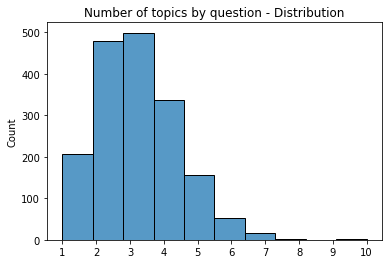

In [104]:
n_topics_by_ques = np.sum(target_dataframe, axis=1)
n_topics_by_ques = n_topics_by_ques.sort_values().values

import matplotlib.pyplot as plt
import seaborn as sns

x_ticks = np.arange(np.min(n_topics_by_ques), np.max(n_topics_by_ques)+1,1)
sns.histplot(n_topics_by_ques, bins=len(x_ticks))
plt.xticks(x_ticks)
plt.title("Number of topics by question - Distribution")
plt.show()

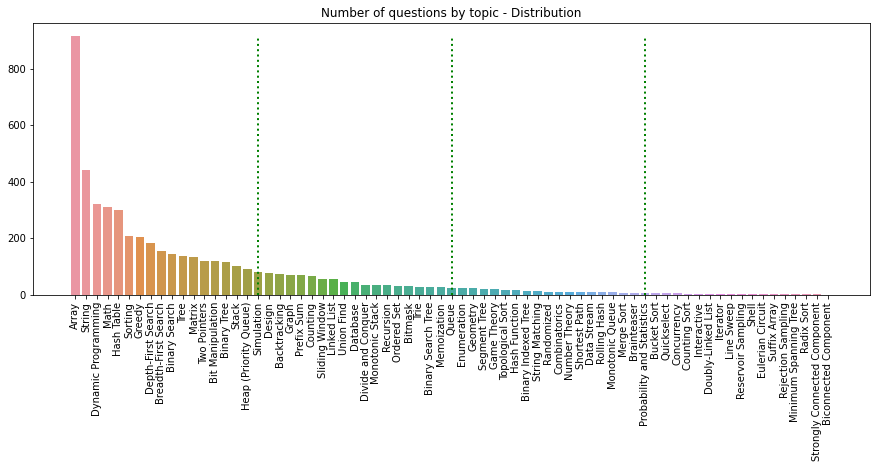

In [133]:
# n_questions by topic

n_ques_by_topics = np.sum(target_dataframe, axis=0)
n_ques_by_topics = n_ques_by_topics.sort_values(ascending=False)

quantile_50th = len(n_ques_by_topics.index)//2
quantile_25th = int(len(n_ques_by_topics.index) * .25)
quantile_75th = int(len(n_ques_by_topics.index) * .75)

fig = plt.figure(figsize=(15,5))
sns.barplot(y = n_ques_by_topics.values, x = n_ques_by_topics.index, orient='v')
plt.vlines(x=quantile_25th, ymin=0, ymax=max(n_ques_by_topics.values), colors='green', ls=':', lw=2, label='vline_single - full height')
plt.vlines(x=quantile_50th, ymin=0, ymax=max(n_ques_by_topics.values), colors='green', ls=':', lw=2, label='vline_single - full height')
plt.vlines(x=quantile_75th, ymin=0, ymax=max(n_ques_by_topics.values), colors='green', ls=':', lw=2, label='vline_single - full height')
# plt.xticks(x_ticks)
plt.title("Number of questions by topic - Distribution")
plt.xticks(rotation=90)
plt.show()

From the above plot let us check what actually is the count of the percentile topics topic

In [139]:
print(f" Number of times Probability and Statistics topic appears: {n_ques_by_topics.loc['Probability and Statistics']}")
print(f" Number of times Queue topic appears: {n_ques_by_topics.loc['Queue']}")
print(f" Number of times Simulation topic appears: {n_ques_by_topics.loc['Simulation']}")

 Number of times Probability and Statistics topic appears: 6
 Number of times Queue topic appears: 25
 Number of times Simulation topic appears: 81


We can see that there is a huge difference between the frequencies, Now a value of 6 out of approx 1700 seems to be so small that it might not add up to the final model, Same goes for the topics that apper less than Prob and Stats<br/>
Therefore as of now, Because we have less data i would not be caring much about these less frequent tags and would be interested more in the more frequent tags, Therefore as an experiment i am removing all the tags that appear in less than 1% of the questions.<br/>
So our data has 1751 rows, Therefore i am selecting a value of 18, if a tag appears less than 18 times we discard that, So lets find out which tags appear less than 18 times:

In [152]:
# As we have sorted data, the 0th index of below statement will give us the index from which tags appear less than 18 times
idx_up = np.where(n_ques_by_topics <= 18)[0][0]
print(idx_up)
"""Therefore up till index 40, tags appear more than 18 times"""

41


'Therefore up till index 40, tags appear more than 18 times'

In [159]:
# Let us find the tags that appear more than 18 times:

# We have the following tags which appear in at least 1% of the questions

n_ques_by_topics.iloc[:idx_up]

Array                    915
String                   440
Dynamic Programming      320
Math                     311
Hash Table               301
Sorting                  209
Greedy                   206
Depth-First Search       183
Breadth-First Search     155
Binary Search            144
Tree                     137
Matrix                   134
Two Pointers             121
Bit Manipulation         119
Binary Tree              117
Stack                    104
Heap (Priority Queue)     90
Simulation                81
Design                    76
Backtracking              73
Graph                     71
Prefix Sum                71
Counting                  68
Sliding Window            58
Linked List               56
Union Find                46
Database                  45
Divide and Conquer        36
Monotonic Stack           36
Recursion                 35
Ordered Set               33
Bitmask                   31
Trie                      28
Binary Search Tree        28
Memoization   

So let us go ahead and remove the tags from target label that we do not need

In [162]:
target_dataframe.drop(list(n_ques_by_topics.iloc[idx_up:].index), axis=1, inplace=True)
target_dataframe.shape

(1751, 41)

Therefore now, we have almost 41 tags that could be useful in predictions, Now lets make our data model ready

<a id='data_model_ready'></a>
## Making data model ready

As of now we have already processed questions, hints and similar questions data, Let us go ahead and process following columns:
1. vectorization of question_title_column
2. Normalization/Standardization of All Numerical columns
3. Removing all the not needed columns - question_slug, quesiton_id,  target

In [167]:
# 1. preprocessing and cleaning of title
df['question_title_processed'] = lowercase(df['question_title'])

# Removing all the not needed columns now:
df.drop(['question_id', 'question_slug', 'question_title', 'target'], axis=1, inplace=True)

df.head(5)

,difficulty,success_rate,total_accepted,total_submissions,question_text_cleaned,hints_processed,similar_question_text_processed,dislike_by_like_ratio,has_similar_easy,has_similar_medium,has_similar_hard,question_title_processed
0,1,48.4,6255310,12924189,given array integers nums integer target retur...,really brute force way would search possible p...,sum sum two sum ii input array is sorted two s...,0.031410,1,1,0,two sum
1,2,38.4,2644334,6888606,you given two nonempty linked lists representi...,nonexistent,multiply strings add binary sum two integers a...,0.207573,1,1,0,add two numbers
2,2,32.9,3109972,9438634,given string find length longest substring wit...,nonexistent,longest substring at most two distinct charact...,0.044813,0,1,1,longest substring without repeating characters
3,3,33.9,1312772,3874658,given two sorted arrays nums nums size respect...,nonexistent,nonexistent,0.123785,0,0,0,median of two sorted arrays
4,2,31.7,1752820,5525765,given string return longest palindromic substring,how reuse previously computed palindrome compu...,shortest palindrome palindrome permutation pal...,0.058627,1,1,1,longest palindromic substring


<b>Metric</b>

Some topics here occur so many times some appear very few times, Maybe the number of times the last ropic occurs would be so small that the model wont have enough data itself to learn any pattern, as the frequency of occurance of topics is very different we can select <b>micro averaged f1 score</b> as the performance metric

<b>Splitting the data</b>


For now we are just going with 80-20 random split

In [181]:
from sklearn.model_selection import train_test_split, GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(df, target_dataframe, test_size=0.2)

<a id='featurization'></a>
## Featurization

In [182]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler

preprocessors = {}

training_data = []
testing_data = []

text_feature = ['question_text_cleaned', 'hints_processed', 'similar_question_text_processed', 'question_title_processed']
numerical_features = ['difficulty', 'success_rate', 'total_accepted', 'total_submissions', 'dislike_by_like_ratio']

# TFIDF on text features
for feature in text_feature:
    preprocessors[feature] = TfidfVectorizer()
    training_data.append(preprocessors[feature].fit_transform(x_train[feature]))
    testing_data.append(preprocessors[feature].transform(x_test[feature]))
    
# standard Scaler on numerical features
for feature in numerical_features:
    preprocessors[feature] = StandardScaler()
    training_data.append(preprocessors[feature].fit_transform(np.array(x_train[feature]).reshape(-1,1)))
    testing_data.append(preprocessors[feature].transform(np.array(x_test[feature]).reshape(-1,1)))

In [183]:
## adding remaining features, and stacking them 

training_data.append(x_train['has_similar_easy'].values.reshape(-1,1))
training_data.append(x_train['has_similar_medium'].values.reshape(-1,1))
training_data.append(x_train['has_similar_hard'].values.reshape(-1,1))

testing_data.append(x_test['has_similar_easy'].values.reshape(-1,1))
testing_data.append(x_test['has_similar_medium'].values.reshape(-1,1))
testing_data.append(x_test['has_similar_hard'].values.reshape(-1,1))


from scipy.sparse import hstack

xtrain = hstack(training_data).tocsr()
xtest = hstack(testing_data).tocsr()

<p id='training'></p>

## Model Training

In [251]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

# Training the classifier
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.0001))
clf.fit(xtrain, y_train)

OneVsRestClassifier(estimator=SGDClassifier(loss='log'))

<a id='summary'></a>
## Summary Report

In [252]:
print("f1 Score (Macro Averaged): {}".format(metrics.f1_score(y_test, clf.predict(xtest), average='macro')))
print("f1 Score (Micro Averaged): {}".format(metrics.f1_score(y_test, clf.predict(xtest), average='micro')))
print("Precision: {}".format(metrics.precision_score(y_test, clf.predict(xtest), average='micro')))
print("Recall: {}".format(metrics.recall_score(y_test, clf.predict(xtest), average='micro')))
print()
print('Classification Report:\n{}'.format(metrics.classification_report(y_test, clf.predict(xtest))))

f1 Score (Macro Averaged): 0.3871953440666432
f1 Score (Micro Averaged): 0.5986394557823129
Precision: 0.7806451612903226
Recall: 0.485456369107322

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.40      0.52        57
           1       0.71      0.48      0.57        60
           2       0.83      0.54      0.66        37
           3       0.80      0.19      0.31        21
           4       0.84      0.90      0.87       187
           5       1.00      0.29      0.44         7
           6       0.56      0.31      0.40        65
           7       0.56      0.23      0.33        39
           8       0.85      0.94      0.89        18
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         4
          11       0.09      0.12      0.11         8
          12       0.40      0.17      0.24        12
          13       0.80      0.17      0.28        24
          14     

C:\Users\rohit\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohit\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rohit\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id='conc'></a>
## Conclusion

1. By looking at the summary report and all the metric values, It seems that the model is indeed performing good.


2. We have a pretty good value for micro averaged f1 score = 0.5921 which will be considered good given the number of training points we have and the number of classes


3. The Precision scores is pretty good, Precision of 0.77 given the data that we have should be considered a pretty good score, This could indeed be increased by adding in more data and balancing the class labels


4. The recall score is fine but not as good as precision score


5. Precision recall for each class seems to be good other than the classes 9, 11, 20, 26, 27, 28, 31 etc the topics for which would be in 'Topological Sort, Enumeration, Union Find', 'Sliding Window', 'Game Theory', These are the topics which have very less number of data points


6. Adding more data could easily improve the model, Having better featurizations and preprocessing would still help the majority data point classes and would improve the score, but would do no benifit for the other Topics that are in minority.

## Further work - 
1. We can check feature importance and remove all the non important features and then try to retrain model and compare results
2. Try with much more complex models like GBDT's.